In [1]:
import control as ct, numpy as np
from json import load
from design import *
from control_utilities import *

# Função de transferência do controlador PID:
# $$G_c(s) = K\cdot\frac{(s+a)^2}{s}$$
# Função de transferência do compensador por avanço de fase:
# $$G_c(s) = K\cdot\frac{s+z_c}{s+p_c}$$
# Função de transferência do compensador por avanço-atraso de fase:
# $$G_c(s) = K\cdot\frac{s+z_{c1}}{s+p_{c1}}\frac{s+z_{c2}}{s+p_{c2}}$$

In [2]:
y_min = 0
overshoot = 0.1
ts = 2
T = 5e-3
time = np.arange(0, 7, 5e-3)

## Motor panorâmico

In [3]:
path = "../system_parameters/"
with open(f"{path}motor_pan.info", "r") as file:
    params = load(file)
tau, K = params["tau"], params["K"]

In [4]:
pan = create_servo(K, tau)
pan

TransferFunction(array([0.64206706]), array([0.14737725, 1.        , 0.        ]))

In [5]:
pan_z = ct.c2d(pan, 5e-3)
pan_z

TransferFunction(array([5.38471157e-05, 5.32416024e-05]), array([ 1.        , -1.96664251,  0.96664251]), 0.005)

In [6]:
pid_pan = design_pid_computational(sys=pan, overshoot=overshoot, ts=ts, discrete=True, method="backward", T=T)
pid_pan

TransferFunction(array([ 2.56289063, -5.0625    ,  2.5       ]), array([ 0.005, -0.005,  0.   ]), 0.005)

In [7]:
lead_pan = ct.c2d(design_lead_bissect(sys=pan, overshoot=overshoot, ts=ts), T)
lead_pan

TransferFunction(array([ 5.31434759, -5.24273863]), array([ 1.        , -0.97920451]), 0.005)

In [8]:
lead_lag_pan = ct.c2d(lead_lag(sys=pan, overshoot=overshoot, ts=ts), T)
lead_lag_pan

TransferFunction(array([ 2.62728551+0.j, -5.16296936+0.j,  2.53579611+0.j]), array([ 1.        , -1.97949619,  0.9795101 ]), 0.005)

/home/nikolas/.local/lib/python3.10/site-packages/control/statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)


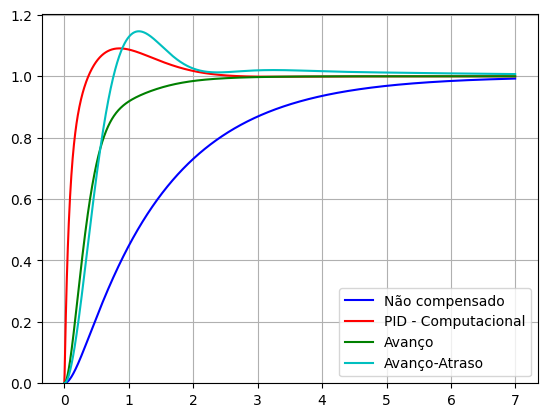

In [9]:
_ = compare_step(sys=[pan_z, pid_pan*pan_z, lead_pan*pan_z, lead_lag_pan*pan_z], time=time, labels=("Não compensado", "PID - Computacional", "Avanço", "Avanço-Atraso"), y_min=y_min)

In [10]:
diff_eq = z2t(lead_pan)
print(diff_eq)

tf_to_json(lead_pan, "/home/nikolas/Documents/GitHub/Controller/system_parameters/controller_pan.info")

uN_0 = 0.9792045104124105*uN_1 + 5.314347593844756*errN_0 - 5.242738626445766*errN_1


## Motor tilt

In [11]:
path = "../system_parameters/"
with open(f"{path}motor_tilt.info", "r") as file:
    params = load(file)
tau, K = params["tau"], params["K"]

In [12]:
tilt = create_servo(K, tau)
tilt

TransferFunction(array([0.51245659]), array([0.14464497, 1.        , 0.        ]))

In [13]:
tilt_z = ct.c2d(tilt, T)
tilt_z

TransferFunction(array([4.37798224e-05, 4.32782705e-05]), array([ 1.        , -1.96602323,  0.96602323]), 0.005)

In [14]:
pid_tilt = design_pid_computational(sys=tilt, overshoot=overshoot, ts=ts, discrete=True, method="backward", T=T)
pid_tilt

TransferFunction(array([ 3.17798437, -6.2775    ,  3.1       ]), array([ 0.005, -0.005,  0.   ]), 0.005)

In [15]:
tilt_z = ct.c2d(tilt, 5e-3)

In [16]:
lead_tilt = ct.c2d(design_lead_bissect(sys=tilt, overshoot=overshoot, ts=ts), T)
lead_tilt

TransferFunction(array([ 6.70809238, -6.61825562]), array([ 1.       , -0.9790793]), 0.005)

In [17]:
lead_lag_tilt = ct.c2d(lead_lag(sys=tilt, overshoot=overshoot, ts=ts), T)
lead_lag_tilt

TransferFunction(array([ 3.2307509 +0.j, -6.34680956+0.j,  3.11619931+0.j]), array([ 1.        , -1.97949619,  0.9795101 ]), 0.005)

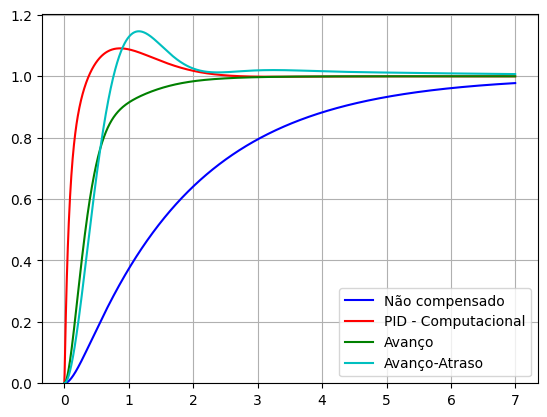

In [18]:
_ = compare_step(sys=[tilt_z, pid_tilt*tilt_z, lead_tilt*tilt_z, lead_lag_tilt*tilt_z], time=time, labels=("Não compensado", "PID - Computacional", "Avanço", "Avanço-Atraso"), y_min=y_min)

In [19]:
diff_eq = z2t(lead_tilt)
print(diff_eq)

tf_to_json(lead_tilt, "/home/nikolas/Documents/GitHub/Controller/system_parameters/controller_tilt.info")

uN_0 = 0.9790793003839892*uN_1 + 6.708092377937437*errN_0 - 6.6182556152627825*errN_1
